![logo](./img/LogoLine_horizon_CAMS.png)

<br>

# European Air Quality Index Calculation

### About

This notebook provides you a practical introduction to the calculation and interpretation of the `Air Quality Index (AQI)` in Europe. Air pollution is the single largest environmental health risk in Europe, causing cardiovascular and respiratory diseases, that, in the most serious cases, lead to premature deaths.
The European Environment Agency's European Air Quality Index allows users to understand more about air quality where they live. Even though the air quality in Europe has improved over recent decades, the levels of air pollutants still exceed EU standards and the most stringent World Health Organization (WHO) guidelines.

#### How is the European Air Quality index defined?
The European Air Quality index is computed for five main pollutants regulated in the European legislation:
* `Ozone (O3)`
* `Nitrogen Dioxide (NO2)`
* `Sulphur Dioxide (SO2)`
* `Fine particulate matter with a diameter smaller than 2.5 micrometers (PM2.5)`
* `Fine particulate matter with a diameter smaller than 10 micrometers (PM10)`


The index ranges from 1 (good) to 6 (extremely poor). For each pollutant, the index is calculated separately according to the concentrations; the higher the concentrations, the higher the index (see Table below for index levels). The overall hourly European Air Quality index is simply defined as the highest value of the five individual pollutants indexes computed for the same hour. For instance, if the indices relative to O<sub>3</sub>, NO<sub>2</sub>, SO<sub>2</sub>, PM2.5 and PM10 are 1,3,1,2,2 respectively, the overall index will be 3. The overall daily European Air Quality index is the highest value of the overall hourly European Air Quality index in the corresponding day.


![logo](./img/eaqi_index_level.png)


<br>

The notebook has the following outline:

* 1 - Compute the European Air Quality Index for Europe for one day in July 2021
  * 1.1 - Request data from the ADS programmatically with the CDS API
  * 1.2 - Load and prepare the European air quality forecast data
  * 1.3 - Classify daily maximum pollutant values into European Air Quality Index levels
  * 1.4 - Visualize a map of Air Quality Index levels in Europe for 15 July 2021
* 2 - Calculate the daily European Air Quality Index for London in December 2020
  * 2.1 - Request data from the ADS programmatically with the CDS API
  * 2.2 - Load and prepare the European air quality forecast data
  * 2.3 - Select time-series information for London, UK and convert to a pandas dataframe
  * 2.4 - Classify daily maximum values of key pollutants into European Air Quality Index levels
  * 2.5 - Visualize daily European Air Quality Index for London in December 2020 as heatmap


### Data

This notebook introduces you to the [CAMS European air quality forecasts and analysis]((https://ads-beta.atmosphere.copernicus.eu/datasets/cams-europe-air-quality-forecasts?tab=overview)) dataset. The data has the following specifications:

> **Data**: `CAMS European air quality forecasts` <br>
> **Temporal coverage**: `three-year rolling archive` <br>
> **Temporal resolution**: `hourly` <br>
> **Spatial coverage**: `Europe` <br>
> **Spatial resolution**: `0.1° x 0.1°` <br>
> **Format**: `NetCDF`<br>


### Further resources

* [Air pollution - European Environment Agency](https://www.eea.europa.eu/themes/air)
* [Europe's air quality status 2021](https://www.eea.europa.eu/publications/air-quality-status-2021/air-quality-status-briefing-2021)
* [Air pollution stil too high in most EU Member States](https://www.eea.europa.eu/highlights/air-pollution-still-too-high-1)
* [Euronews: Copernicus air quality index](https://www.euronews.com/weather/copernicus-air-quality-index)

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-cams/master?labpath=proc-aq-index.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-cams/blob/master/proc-aq-index.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-cams/blob/master/proc-aq-index.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

<hr>

### Install CDSAPI via pip

In [1]:
!pip install cdsapi

### Load libraries

In [1]:
# CDS API
import cdsapi
import os

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from matplotlib.colors import ListedColormap

from datetime import datetime

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import seaborn as sns

<hr>

## 1. Compute the European Air Quality Index for Europe for one day in July 2021

As a first example, we want to compute and visualize the European Air Quality Index for Europe for one day in July 2021.

### 1.1 Request data from the ADS programmatically with the CDS API

Let us request data from the Atmosphere Data Store programmatically with the help of the CDS API. Let us set manually the CDS API credentials. First, you have to define two variables: `URL` and `KEY` which build together your CDS API key. Below, you have to replace the `#########` with your personal ADS key. Please find [here](https://ads-beta.atmosphere.copernicus.eu/how-to-api) your personal ADS key.

In [2]:
URL = 'https://ads-beta.atmosphere.copernicus.eu/api'
KEY = '############################################'

<br>

The next step is then to request the data with the help of the CDS API. Below, we request analysis data from the `CAMS European air quality forecasts` dataset. We request hourly data for 15 July 2021 for the five main pollutants for which the European Air Quality Index is calculated: `nitrogen_dioxide`, `ozone`, `particulate_matter_10um`, `particulate_matter_2.5um` and `sulphur_dioxide`.

Let us store the dataset under the name `20210715_eaqi_europe.nc`.

In [3]:
import cdsapi

dataset = "cams-europe-air-quality-forecasts"
request = {
    'variable': ['nitrogen_dioxide', 'ozone', 
                 'particulate_matter_2.5um', 
                 'particulate_matter_10um', 'sulphur_dioxide'],
    'model': ['ensemble'],
    'level': ['0'],
    'date': ['2021-07-15/2021-07-15'],
    'type': ['analysis'],
    'time': ['00:00', '01:00', '02:00', '03:00', '04:00', 
             '05:00', '06:00', '07:00', '08:00', '09:00', 
             '10:00', '11:00', '12:00', '13:00', '14:00', 
             '15:00', '16:00', '17:00', '18:00', '19:00', 
             '20:00', '21:00', '22:00', '23:00'],
    'leadtime_hour': ['0'],
    'data_format': 'netcdf'
}

client = cdsapi.Client(url=URL, key=KEY)
client.retrieve(dataset, request).download(
    './20210715_eaqi_europe.nc')

2024-09-12 22:14:31,043 INFO Request ID is 65223b2f-bc52-4484-8119-14464d0bac12
2024-09-12 22:14:31,118 INFO status has been updated to accepted
2024-09-12 22:14:32,687 INFO status has been updated to running
2024-09-12 22:14:43,587 INFO status has been updated to successful


fe651abc560116e8cc2de45546ac24e6.nc:   0%|          | 0.00/135M [00:00<?, ?B/s]

'./20210715_eaqi_europe.nc'

<br>

### 1.2 Load and prepare the European air quality forecast data

The European air quality forecast data are available either in `GRIB` or in `NetCDF` format. Above, we requested the data in the `NetCDF` format. You can use the Python library [xarray](http://xarray.pydata.org/en/stable/) and the function `open_dataset()` to load a NetCDF file as `xarray.Dataset`. A xarray Dataset is a collection of one or more variables that share the same dimensions. Below, you see that the Dataset has four dimensions, `latitude`, `level`, `longitude` and `time`, and five variables, `no2_conc`, `o3_conc`, `pm10_conc`, `pm2p5_conc` and `so2_conc`.

In [4]:
eaqi = xr.open_dataset('./20210715_eaqi_europe.nc')
eaqi

<xarray.Dataset>
Dimensions:     (longitude: 700, latitude: 420, level: 1, time: 24)
Coordinates:
  * longitude   (longitude) float32 335.0 335.1 335.2 ... 44.75 44.85 44.95
  * latitude    (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * level       (level) float32 0.0
  * time        (time) timedelta64[ns] 00:00:00 01:00:00 ... 22:00:00 23:00:00
Data variables:
    no2_conc    (time, level, latitude, longitude) float32 ...
    o3_conc     (time, level, latitude, longitude) float32 ...
    pm10_conc   (time, level, latitude, longitude) float32 ...
    pm2p5_conc  (time, level, latitude, longitude) float32 ...
    so2_conc    (time, level, latitude, longitude) float32 ...
Attributes:
    title:        NO2/O3/PM10/PM25/SO2 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20210715+[0H_23H]
    summary:      ENSEMBLE model hourly ANALYSIS of NO2/O3/PM10/PM25/SO2 conc...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

<br>

Let us have a closer look at the coordinates of the dataset. You see above that the dataset consists of 24 time steps and that the longitude values are on a [0, 360] grid. 

However, if you inspect the time dimension more in detail, you see that the time is given in nanoseconds [ns]. Hence, as a next step, let us convert the time information into a human-readable time format and bring the longitude coordinates to a [-180, 180] grid.

In [5]:
eaqi.time

<xarray.DataArray 'time' (time: 24)>
array([             0,  3600000000000,  7200000000000, 10800000000000,
       14400000000000, 18000000000000, 21600000000000, 25200000000000,
       28800000000000, 32400000000000, 36000000000000, 39600000000000,
       43200000000000, 46800000000000, 50400000000000, 54000000000000,
       57600000000000, 61200000000000, 64800000000000, 68400000000000,
       72000000000000, 75600000000000, 79200000000000, 82800000000000],
      dtype='timedelta64[ns]')
Coordinates:
  * time     (time) timedelta64[ns] 00:00:00 01:00:00 ... 22:00:00 23:00:00
Attributes:
    long_name:  ANALYSIS time from 20210715

First, from the `long_name` information of the time dimension (see above), we can retrieve the initial timestamp. With the function `strptime()` from Python's `datetime` library, we can convert it into a `datetime.datetime` object.

In [6]:
timestamp = eaqi.time.long_name[19:27]

timestamp_init=datetime.strptime(timestamp,'%Y%m%d' )
timestamp_init

datetime.datetime(2021, 7, 15, 0, 0)

In a next step, we then build a `DateTimeIndex` object with the help of Panda's `date_range()` function, making use of the length of the time dimension. The result is a `DateTimeIndex` object, which can be used to newly assign the time coordinate information.

In [7]:
time_coords = pd.date_range(timestamp_init, periods=len(eaqi.time), freq='1h').strftime("%Y-%m-%d %H:%M:%S").astype('datetime64[ns]')
time_coords

DatetimeIndex(['2021-07-15 00:00:00', '2021-07-15 01:00:00',
               '2021-07-15 02:00:00', '2021-07-15 03:00:00',
               '2021-07-15 04:00:00', '2021-07-15 05:00:00',
               '2021-07-15 06:00:00', '2021-07-15 07:00:00',
               '2021-07-15 08:00:00', '2021-07-15 09:00:00',
               '2021-07-15 10:00:00', '2021-07-15 11:00:00',
               '2021-07-15 12:00:00', '2021-07-15 13:00:00',
               '2021-07-15 14:00:00', '2021-07-15 15:00:00',
               '2021-07-15 16:00:00', '2021-07-15 17:00:00',
               '2021-07-15 18:00:00', '2021-07-15 19:00:00',
               '2021-07-15 20:00:00', '2021-07-15 21:00:00',
               '2021-07-15 22:00:00', '2021-07-15 23:00:00'],
              dtype='datetime64[ns]', freq=None)

And the last step is to assign the converted time information to the loaded xarray.Dataset `eaqi`, with the function `assign_coords()`.

In [8]:
eaqi_assigned = eaqi.assign_coords(time=time_coords)
eaqi_assigned

<xarray.Dataset>
Dimensions:     (longitude: 700, latitude: 420, level: 1, time: 24)
Coordinates:
  * longitude   (longitude) float32 335.0 335.1 335.2 ... 44.75 44.85 44.95
  * latitude    (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * level       (level) float32 0.0
  * time        (time) datetime64[ns] 2021-07-15 ... 2021-07-15T23:00:00
Data variables:
    no2_conc    (time, level, latitude, longitude) float32 ...
    o3_conc     (time, level, latitude, longitude) float32 ...
    pm10_conc   (time, level, latitude, longitude) float32 ...
    pm2p5_conc  (time, level, latitude, longitude) float32 ...
    so2_conc    (time, level, latitude, longitude) float32 ...
Attributes:
    title:        NO2/O3/PM10/PM25/SO2 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20210715+[0H_23H]
    summary:      ENSEMBLE model hourly ANALYSIS of NO2/O3/PM10/PM25/SO2 conc...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

<br>

Now, let us also re-assign the longitude values and shift the grid from [0,360] to [-180,180]. At the end, you might want to sort the longitude values in an ascending order. You can re-assign coordinate values with the xarray function `assign_coords()`.

In [9]:
eaqi_assigned = eaqi_assigned.assign_coords(longitude=(((eaqi_assigned.longitude + 180) % 360) - 180)).sortby('longitude')
eaqi_assigned

<xarray.Dataset>
Dimensions:     (longitude: 700, latitude: 420, level: 1, time: 24)
Coordinates:
  * longitude   (longitude) float32 -24.95 -24.85 -24.75 ... 44.75 44.85 44.95
  * latitude    (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * level       (level) float32 0.0
  * time        (time) datetime64[ns] 2021-07-15 ... 2021-07-15T23:00:00
Data variables:
    no2_conc    (time, level, latitude, longitude) float32 ...
    o3_conc     (time, level, latitude, longitude) float32 ...
    pm10_conc   (time, level, latitude, longitude) float32 ...
    pm2p5_conc  (time, level, latitude, longitude) float32 ...
    so2_conc    (time, level, latitude, longitude) float32 ...
Attributes:
    title:        NO2/O3/PM10/PM25/SO2 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20210715+[0H_23H]
    summary:      ENSEMBLE model hourly ANALYSIS of NO2/O3/PM10/PM25/SO2 conc...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

<br>

Let us now also resample the hourly concentrations of the five pollutants and extract for each pollutant the maximum value for each day. The result is that the Dataset remains with only one entry of the time dimension.

In [10]:
eaqi_daily = eaqi_assigned.resample(time='1D').max()
eaqi_daily

<xarray.Dataset>
Dimensions:     (longitude: 700, latitude: 420, level: 1, time: 1)
Coordinates:
  * longitude   (longitude) float32 -24.95 -24.85 -24.75 ... 44.75 44.85 44.95
  * latitude    (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * level       (level) float32 0.0
  * time        (time) datetime64[ns] 2021-07-15
Data variables:
    no2_conc    (time, level, latitude, longitude) float32 0.01735 ... 0.2321
    o3_conc     (time, level, latitude, longitude) float32 53.11 52.12 ... 118.9
    pm10_conc   (time, level, latitude, longitude) float32 17.47 18.59 ... 216.6
    pm2p5_conc  (time, level, latitude, longitude) float32 17.06 18.18 ... 30.75
    so2_conc    (time, level, latitude, longitude) float32 0.01546 ... 2.877
Attributes:
    title:        NO2/O3/PM10/PM25/SO2 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20210715+[0H_23H]
    summary:      ENSEMBLE model hourly ANALYSIS of NO2/O3/PM10/PM25/SO2 conc...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

Let us now also drop the dimensions `time` and `level`, which only have one record each. The xarray function `squeeze()` drops all dimensions with only one entry. The result is a dataset with two remaining dimensions: `latitude` and `longitude`.

In [11]:
eaqi_daily = eaqi_daily.squeeze(drop=True)
eaqi_daily

<xarray.Dataset>
Dimensions:     (longitude: 700, latitude: 420)
Coordinates:
  * longitude   (longitude) float32 -24.95 -24.85 -24.75 ... 44.75 44.85 44.95
  * latitude    (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
Data variables:
    no2_conc    (latitude, longitude) float32 0.01735 0.01819 ... 0.2072 0.2321
    o3_conc     (latitude, longitude) float32 53.11 52.12 52.21 ... 117.8 118.9
    pm10_conc   (latitude, longitude) float32 17.47 18.59 18.56 ... 191.4 216.6
    pm2p5_conc  (latitude, longitude) float32 17.06 18.18 18.25 ... 30.45 30.75
    so2_conc    (latitude, longitude) float32 0.01546 0.01864 ... 2.263 2.877
Attributes:
    title:        NO2/O3/PM10/PM25/SO2 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20210715+[0H_23H]
    summary:      ENSEMBLE model hourly ANALYSIS of NO2/O3/PM10/PM25/SO2 conc...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

### 1.3 Classify daily maximum concentration values into European Air Quality Index levels

Now, we can classify the daily maximum concentration values into European Air Quality index levels. For this, we first define for each key pollutant the thresholds and save these as a list of threshold limits. In a next step, we combine the threshold lists into a list of lists, which we call `bin_list`.

In [12]:
no2_limits = [0, 40, 90, 120, 230, 340, 1000]
ozone_limits = [0, 50, 100, 130, 240, 380, 800]
pm10_limits = [0, 10, 20, 25, 50, 75, 800]
pm25_limits = [0, 20, 40, 50, 100, 150, 1200]
so2_limits = [0, 100, 200, 350, 500, 750, 1250]

bin_list = [no2_limits, ozone_limits, pm10_limits, pm25_limits, so2_limits]
bin_list

[[0, 40, 90, 120, 230, 340, 1000],
 [0, 50, 100, 130, 240, 380, 800],
 [0, 10, 20, 25, 50, 75, 800],
 [0, 20, 40, 50, 100, 150, 1200],
 [0, 100, 200, 350, 500, 750, 1250]]

<br>

The next step is then to store all variables available in the xarray.Dataset `eaqi_daily` in a list with the name `variable_list`.

In [13]:
variable_list = list(eaqi_daily.variables)[2:]
variable_list

['no2_conc', 'o3_conc', 'pm10_conc', 'pm2p5_conc', 'so2_conc']

<br>

Now, we can loop over all data variables in the dataset and apply a customized function with the `apply_ufunc()` functionality of xarray:
* `function()`: apply the numpy function `digitize()`, which returns the indices of the bins (thresholds) to which each value in the input array belongs to
* `input array`: provide input data array, whose values shall be classified
* `list of thresholds (bin)`: provide list of thresholds, groups of bins

At the end, we create a list of all classified data arrays, which has the name `classified_arrays`.

In [14]:
classified_arrays = []
for i in range(0,len(eaqi_daily)):
    variable = variable_list[i]
    temp = xr.apply_ufunc(np.digitize,
              eaqi_daily[variable],
              bin_list[i])
    classified_arrays.append(temp)

<br>

The function `merge()` allows us to merge the list of xarray.DataArray items into a xarray.Dataset. The resulting dataset has again five variables, but each grid point of the variable's array is now classified according to the European Air Quality Index levels.

In [15]:
combined = xr.merge(classified_arrays)
combined

<xarray.Dataset>
Dimensions:     (longitude: 700, latitude: 420)
Coordinates:
  * longitude   (longitude) float32 -24.95 -24.85 -24.75 ... 44.75 44.85 44.95
  * latitude    (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
Data variables:
    no2_conc    (latitude, longitude) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    o3_conc     (latitude, longitude) int64 2 2 2 2 2 2 1 1 ... 3 3 3 3 3 3 3 3
    pm10_conc   (latitude, longitude) int64 2 2 2 2 2 2 2 2 ... 6 6 6 6 6 6 6 6
    pm2p5_conc  (latitude, longitude) int64 1 1 1 1 1 1 1 1 ... 2 1 2 2 2 2 2 2
    so2_conc    (latitude, longitude) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1

<br>

The last step before we can visualize the Air Quality Index in Europe for 15 July 2021 is to create the overall daily European Air Quality index based on the maximum index level among the five key pollutants of the respective day. For this, we can tranform the xarray.Dataset above into a xarray.DataArray with the function `to_array()`. The result is a three-dimensional data array and the five data variables will be added as an additional dimension with the name `variable`. From this data array, we can retrieve for each grid point the maximum value across all variables with the function `max()`.

The result is a two-dimensional data array, which holds for each grid point the overall Air Quality Index level.

In [16]:
final_index = combined.to_array().max('variable')
final_index

<xarray.DataArray (latitude: 420, longitude: 700)>
array([[2, 2, 2, ..., 2, 1, 1],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [4, 4, 4, ..., 6, 6, 6],
       [4, 4, 4, ..., 6, 6, 6],
       [4, 4, 4, ..., 6, 6, 6]], dtype=int64)
Coordinates:
  * longitude  (longitude) float32 -24.95 -24.85 -24.75 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05

<br>

### 1.4 Visualize a map of Air Quality Index levels in Europe for 15 July 2021

The last step is now to visualize the overall daily Air Quality Index levels in Europe for 15 July 2021. The visualisation function consists of five main parts:

* **1. Initiate the matplotlib figure**: Initiate a figure and axes objects and add a colorbar
* **2. Plotting function**: Plot the xarray.DataArray with the pcolormesh() function from matplotlib and provide the customized colormap as color range
* **3. Set title of the map**: Set a title to the resulting map
* **4. Customize colorbar entries:** Customize the labels of the colorbar and indicate the index levels from 'very good' to 'extremely poor'
* **5. Add additional features to the map:** Add additional features such as coastlines and a geographic grid 

**Note:** before plotting, we additionally define a customized colormap based on the official EAQI index colors. We also add additionally the labels to the six EAQI index levels, which range from 'Very good' to 'Extremely poor'.

In [17]:
cmap = ListedColormap(['#5AAA5F', '#A7D25C', '#ECD347', '#F5BE41', '#F09235', '#D93322'])
labels = ['Very good', 'Good', 'Medium', 'Poor', 'Very Poor', 'Extremely Poor']

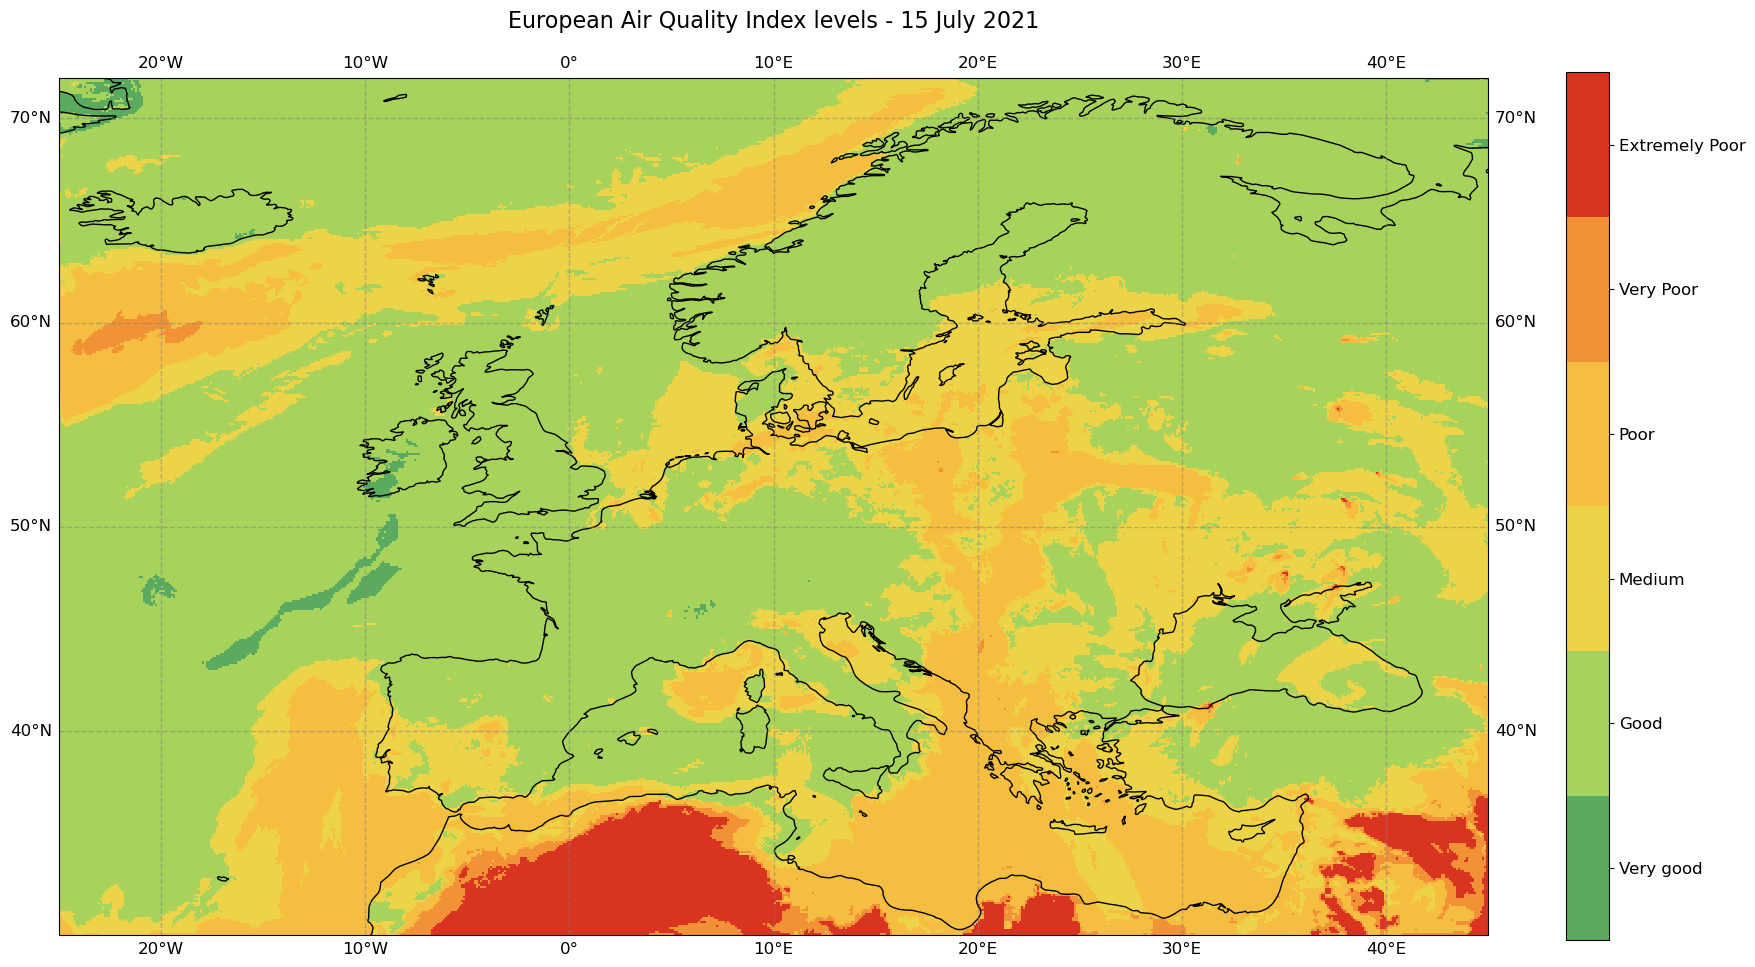

In [18]:
# Initiate a matplotlib figure
fig = plt.figure(figsize=(20,15))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

# Plotting function
img = plt.pcolormesh(final_index.longitude, 
                     final_index.latitude, 
                     final_index, 
                     cmap = cmap,
                     label = labels)

# Set the title of the plot
ax.set_title('European Air Quality Index levels - 15 July 2021', fontsize=16, pad=20.0)

# Customize colorbar
cbar = plt.colorbar(img,fraction=0.028, pad=0.05)
cbar.set_label(None)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks([1.5,2.5,3.5,4.5,5.5,6.5])
cbar.set_ticklabels(labels)

# Add additional features such as coastlines and a geographic grid
ax.coastlines(color='black')
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabel_style={'size':12}
gl.ylabel_style={'size':12}



<br>

## 2. Calculate the daily European Air Quality Index for London in December 2020

Next, we want to calculate the daily European Air Quality Index for London, UK in December 2020.

### 2.1 Request data from the ADS programmatically with the CDS API

We request another dataset with the help of the CDS API. Below, we request analysis data from the `CAMS European air quality forecasts` dataset. We request hourly data for December 2020 for the five main pollutants for which the European Air Quality Index is calculated: `nitrogen_dioxide`, `ozone`, `particulate_matter_10um`, `particulate_matter_2.5um` and `sulphur_dioxide`. In the data request below, we additionally set the `area` key, as we want to tailor the data request to only a small geographical area around London, United Kingdom.

Let us store the dataset under the name `202012_eaqi_london.nc`.

In [21]:
dataset = "cams-europe-air-quality-forecasts"
request = {
    'variable': ['nitrogen_dioxide', 'ozone', 
                 'particulate_matter_2.5um', 
                 'particulate_matter_10um', 'sulphur_dioxide'],
    'model': ['ensemble'],
    'level': ['0'],
    'date': ['2020-12-01/2020-12-31'],
    'type': ['analysis'],
    'time': ['00:00', '01:00', '02:00', '03:00', '04:00', 
             '05:00', '06:00', '07:00', '08:00', '09:00', 
             '10:00', '11:00', '12:00', '13:00', '14:00', 
             '15:00', '16:00', '17:00', '18:00', '19:00', 
             '20:00', '21:00', '22:00', '23:00'],
    'leadtime_hour': ['0'],
    'data_format': 'netcdf',
    'area': [51.6, -0.3, 51.3, 0]
}

client = cdsapi.Client(url=URL, key=KEY)
client.retrieve(dataset, request).download(
    './202012_eaqi_london.nc')

2024-09-12 22:36:05,020 INFO Request ID is dd76ceb8-f4c9-4930-9540-af933b6f0140
2024-09-12 22:36:05,092 INFO status has been updated to accepted
2024-09-12 22:36:06,677 INFO status has been updated to running
2024-09-12 22:42:23,523 INFO status has been updated to successful


9bd62a1798ce4e429b6670e24465a98d.nc:   0%|          | 0.00/136k [00:00<?, ?B/s]

'./202012_eaqi_london.nc'

<br>

### 2.2 Load and prepare the European air quality forecast data

The European air quality forecasts data are available either in `GRIB` or in `NetCDF` format. Above, we requested the data in the `NetCDF` format. You can use the Python library [xarray](http://xarray.pydata.org/en/stable/) and the function `open_dataset()` to load a NetCDF file as `xarray.Dataset`. A xarray Dataset is a collection of one or more variables that share the same dimensions. Below, you see that the Dataset has four dimensions, `latitude`, `level`, `longitude` and `time`, and five variables, `no2_conc`, `o3_conc`, `pm10_conc`, `pm2p5_conc` and `so2_conc`.

In [22]:
eaqi_london = xr.open_dataset('./202012_eaqi_london.nc')
eaqi_london

<xarray.Dataset>
Dimensions:     (longitude: 3, latitude: 3, level: 1, time: 744)
Coordinates:
  * longitude   (longitude) float32 359.8 359.9 360.0
  * latitude    (latitude) float32 51.55 51.45 51.35
  * level       (level) float32 0.0
  * time        (time) timedelta64[ns] 00:00:00 01:00:00 ... 30 days 23:00:00
Data variables:
    no2_conc    (time, level, latitude, longitude) float32 ...
    o3_conc     (time, level, latitude, longitude) float32 ...
    pm10_conc   (time, level, latitude, longitude) float32 ...
    pm2p5_conc  (time, level, latitude, longitude) float32 ...
    so2_conc    (time, level, latitude, longitude) float32 ...
Attributes:
    title:        NO2/O3/PM10/PM25/SO2 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20201201-20201231+[0H_23H]
    summary:      ENSEMBLE model hourly ANALYSIS of NO2/O3/PM10/PM25/SO2 conc...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

<br>

Let us inspect the coordinates of the dataset more in detail. You see above that the dataset consists of 744 time steps and that the longitude values are on a [0, 360] grid. 

However, if you inspect the time dimension more in detail, you see that the time is given in nanoseconds [ns]. As a next step, let us convert the time information into a human-readable time format and bring the longitude coordinates to a [-180, 180] grid.

In [23]:
eaqi_london.time

<xarray.DataArray 'time' (time: 744)>
array([               0,    3600000000000,    7200000000000, ...,
       2667600000000000, 2671200000000000, 2674800000000000],
      dtype='timedelta64[ns]')
Coordinates:
  * time     (time) timedelta64[ns] 00:00:00 01:00:00 ... 30 days 23:00:00
Attributes:
    long_name:  ANALYSIS time from 20201201

First, from the `long_name` information of the time dimension (see above), we can retrieve the initial timestamp. With the function `strptime()` from Python's `datetime` library, we can convert it into a `datetime.datetime` object.

In [24]:
timestamp = eaqi_london.time.long_name[19:27]

timestamp_init=datetime.strptime(timestamp,'%Y%m%d' )
timestamp_init

datetime.datetime(2020, 12, 1, 0, 0)

In a next step, we then build a `DateTimeIndex` object with the help of Panda's `date_range()` function, making use of the length of the time dimension. The result is a `DateTimeIndex` object, which can be used to newly assign the time coordinate information.

In [25]:
time_coords = pd.date_range(timestamp_init, periods=len(eaqi_london.time), freq='1h').strftime("%Y-%m-%d %H:%M:%S").astype('datetime64[ns]')
time_coords

DatetimeIndex(['2020-12-01 00:00:00', '2020-12-01 01:00:00',
               '2020-12-01 02:00:00', '2020-12-01 03:00:00',
               '2020-12-01 04:00:00', '2020-12-01 05:00:00',
               '2020-12-01 06:00:00', '2020-12-01 07:00:00',
               '2020-12-01 08:00:00', '2020-12-01 09:00:00',
               ...
               '2020-12-31 14:00:00', '2020-12-31 15:00:00',
               '2020-12-31 16:00:00', '2020-12-31 17:00:00',
               '2020-12-31 18:00:00', '2020-12-31 19:00:00',
               '2020-12-31 20:00:00', '2020-12-31 21:00:00',
               '2020-12-31 22:00:00', '2020-12-31 23:00:00'],
              dtype='datetime64[ns]', length=744, freq=None)

And the last step is to assign the converted time information to the loaded xarray.Dataset `eaqi_ldn_ts`, with the function `assign_coords()`.

In [26]:
eaqi_london = eaqi_london.assign_coords(time=time_coords)
eaqi_london

<xarray.Dataset>
Dimensions:     (longitude: 3, latitude: 3, level: 1, time: 744)
Coordinates:
  * longitude   (longitude) float32 359.8 359.9 360.0
  * latitude    (latitude) float32 51.55 51.45 51.35
  * level       (level) float32 0.0
  * time        (time) datetime64[ns] 2020-12-01 ... 2020-12-31T23:00:00
Data variables:
    no2_conc    (time, level, latitude, longitude) float32 ...
    o3_conc     (time, level, latitude, longitude) float32 ...
    pm10_conc   (time, level, latitude, longitude) float32 ...
    pm2p5_conc  (time, level, latitude, longitude) float32 ...
    so2_conc    (time, level, latitude, longitude) float32 ...
Attributes:
    title:        NO2/O3/PM10/PM25/SO2 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20201201-20201231+[0H_23H]
    summary:      ENSEMBLE model hourly ANALYSIS of NO2/O3/PM10/PM25/SO2 conc...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

Now, let us also re-assign the longitude values and shift the grid from [0,360] to [-180,180]. At the end, you might want to sort the longitude values in an ascending order. You can re-assign coordinate values with the xarray function `assign_coords()`.

In [27]:
eaqi_london_assigned = eaqi_london.assign_coords(longitude=(((eaqi_london.longitude + 180) % 360) - 180)).sortby('longitude')
eaqi_london_assigned

<xarray.Dataset>
Dimensions:     (longitude: 3, latitude: 3, level: 1, time: 744)
Coordinates:
  * longitude   (longitude) float32 -0.25 -0.15 -0.04999
  * latitude    (latitude) float32 51.55 51.45 51.35
  * level       (level) float32 0.0
  * time        (time) datetime64[ns] 2020-12-01 ... 2020-12-31T23:00:00
Data variables:
    no2_conc    (time, level, latitude, longitude) float32 ...
    o3_conc     (time, level, latitude, longitude) float32 ...
    pm10_conc   (time, level, latitude, longitude) float32 ...
    pm2p5_conc  (time, level, latitude, longitude) float32 ...
    so2_conc    (time, level, latitude, longitude) float32 ...
Attributes:
    title:        NO2/O3/PM10/PM25/SO2 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20201201-20201231+[0H_23H]
    summary:      ENSEMBLE model hourly ANALYSIS of NO2/O3/PM10/PM25/SO2 conc...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

Let us now also drop the dimension `level`, which only has one record, as we requested the data of the five key pollutants on the surface. The xarray function `squeeze()` drops all dimensions with only one entry. The result is a dataset with three dimensions: `latitude`, `longitude` and `time`.

In [28]:
eaqi_london_assigned = eaqi_london_assigned.squeeze(drop=True)
eaqi_london_assigned

<xarray.Dataset>
Dimensions:     (longitude: 3, latitude: 3, time: 744)
Coordinates:
  * longitude   (longitude) float32 -0.25 -0.15 -0.04999
  * latitude    (latitude) float32 51.55 51.45 51.35
  * time        (time) datetime64[ns] 2020-12-01 ... 2020-12-31T23:00:00
Data variables:
    no2_conc    (time, latitude, longitude) float32 ...
    o3_conc     (time, latitude, longitude) float32 ...
    pm10_conc   (time, latitude, longitude) float32 ...
    pm2p5_conc  (time, latitude, longitude) float32 ...
    so2_conc    (time, latitude, longitude) float32 ...
Attributes:
    title:        NO2/O3/PM10/PM25/SO2 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20201201-20201231+[0H_23H]
    summary:      ENSEMBLE model hourly ANALYSIS of NO2/O3/PM10/PM25/SO2 conc...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

<br>

### 2.3 Select time-series information for London, UK and convert to a pandas dataframe

The xarray.Dataset above is now in a format that allows us to select the values of the pollutants for one single grid point. Let us first define variables for the latitude and longitude coordinates for London, United Kingdom. These two variables can then be used to select the values for one single grid point. You can use xarray's function `sel()` to make a coordinate-based selection. Let us set the keyword argument `method='nearest'`, which selects the information that belongs to the closest grid point to the provided latitude and longitude inputs.

The resulting dataset remains with `time` as the only dimension.

In [29]:
london_lat = 51.5
london_lon = -0.1

eaqi_ldn_ts = eaqi_london_assigned.sel(latitude=london_lat, longitude=london_lon, method='nearest')
eaqi_ldn_ts

<xarray.Dataset>
Dimensions:     (time: 744)
Coordinates:
    longitude   float32 -0.04999
    latitude    float32 51.55
  * time        (time) datetime64[ns] 2020-12-01 ... 2020-12-31T23:00:00
Data variables:
    no2_conc    (time) float32 ...
    o3_conc     (time) float32 ...
    pm10_conc   (time) float32 ...
    pm2p5_conc  (time) float32 ...
    so2_conc    (time) float32 ...
Attributes:
    title:        NO2/O3/PM10/PM25/SO2 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20201201-20201231+[0H_23H]
    summary:      ENSEMBLE model hourly ANALYSIS of NO2/O3/PM10/PM25/SO2 conc...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

<br>

Our aim is to compute the daily European Air Quality Index for London for every day in December 2020. Hence, as a next step we want to resample the hourly data to a daily resolution. As resample function, we use `max()`, which selects for every key pollutant the maximum value per day. You can use the function `resample()` to aggregated the hourly information to daily maximum values. The result is a decrease of the time dimension entries from 744 to 31, one entry for every day in December 2020.

In [30]:
eaqi_lnd_ts_daily = eaqi_ldn_ts.resample(time='1D').max()
eaqi_lnd_ts_daily

<xarray.Dataset>
Dimensions:     (time: 31)
Coordinates:
    longitude   float32 -0.04999
    latitude    float32 51.55
  * time        (time) datetime64[ns] 2020-12-01 2020-12-02 ... 2020-12-31
Data variables:
    no2_conc    (time) float64 40.36 56.89 68.65 54.39 ... 55.01 64.27 44.75
    o3_conc     (time) float64 51.21 15.42 46.31 45.89 ... 26.5 32.19 29.06
    pm10_conc   (time) float64 22.57 45.81 26.58 15.62 ... 40.52 35.14 33.25
    pm2p5_conc  (time) float64 13.9 31.49 17.76 12.67 ... 25.5 30.45 24.3 24.22
    so2_conc    (time) float64 6.562 21.72 13.44 6.705 ... 17.04 10.97 23.9 11.0
Attributes:
    title:        NO2/O3/PM10/PM25/SO2 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20201201-20201231+[0H_23H]
    summary:      ENSEMBLE model hourly ANALYSIS of NO2/O3/PM10/PM25/SO2 conc...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

<br>

Above, the xarray.Dataset holds the daily time-series information for London for the five main pollutants. The Python library [pandas](https://pandas.pydata.org/) is very effective in handling time-series data and offers an interface to xarray. Let us convert the xarray.Dataset above to a pandas.DataFrame with the function `to_dataframe()`. The result is a dataframe with 31 row entries and seven columns, including longitude and latitude information as well as the maximum daily values for each main pollutant.

In [31]:
eaqi_ts_daily_df = eaqi_lnd_ts_daily.to_dataframe()
eaqi_ts_daily_df

,longitude,latitude,no2_conc,o3_conc,pm10_conc,pm2p5_conc,so2_conc
time,,,,,,,
2020-12-01,-0.049988,51.549999,40.360981,51.209736,22.570604,13.902804,6.562004
2020-12-02,-0.049988,51.549999,56.892639,15.424085,45.809910,31.491850,21.718649
2020-12-03,-0.049988,51.549999,68.645248,46.312866,26.582747,17.763401,13.441649
2020-12-04,-0.049988,51.549999,54.392933,45.893066,15.623908,12.668585,6.704823
2020-12-05,-0.049988,51.549999,45.801853,49.884430,17.493584,13.535539,6.376126
2020-12-06,-0.049988,51.549999,41.127209,35.249939,38.035538,28.093002,5.623093
2020-12-07,-0.049988,51.549999,54.871750,18.775467,36.344421,36.085228,10.280019
2020-12-08,-0.049988,51.549999,56.589455,9.765294,43.291382,34.626175,18.309492
2020-12-09,-0.049988,51.549999,60.274017,31.233099,30.912859,15.796569,8.295956


<br>

### 2.4 Classify daily maximum values of key pollutants into European Air Quality Index levels

The next step is now to classify the daily maximum values into the respective European Air Quality Index levels. The EAQI has six index levels and different thresholds for each of the five key pollutants. First, we define the limits for each pollutant and define additionally a list with the index class labels 1 to 6.

In [32]:
ozone_limits = [0, 50, 100, 130, 240, 380, 800]
no2_limits = [0, 40, 90, 120, 230, 340, 1000]
so2_limits = [0, 100, 200, 350, 500, 750, 1250]
pm25_limits = [0, 20, 40, 50, 100, 150, 1200]
pm10_limits = [0, 10, 20, 25, 50, 75, 800]

index_levels = [1, 2, 3, 4, 5, 6]

<br>

Based on the thresholds above, we now classify the daily maximum values of each pollutant into the respective European Air Quality Index level. The pandas function `cut()` allows us to categorize the daily maximum values into index levels. The function takes the following keyword arguments:
* pandas.Series for each pollutant, which shall be categorized
* list of thresholds for each pollutant
* list with index labels

As a result, for each pollutant, the daily maximum value has been classified into one of the six index level classes, based on the pollutant thresholds.

In [33]:
ozone = pd.cut(eaqi_ts_daily_df['o3_conc'], ozone_limits , labels = index_levels)
no2 = pd.cut(eaqi_ts_daily_df['no2_conc'], no2_limits , labels = index_levels)
so2 = pd.cut(eaqi_ts_daily_df['so2_conc'], so2_limits , labels = index_levels)
pm25 = pd.cut(eaqi_ts_daily_df['pm2p5_conc'], pm25_limits , labels = index_levels)
pm10 = pd.cut(eaqi_ts_daily_df['pm10_conc'], pm10_limits , labels = index_levels)

<br>

In a next step, we want to bring together the categorized pandas.Series objects above into one pandas.DataFrame. For this, we can use the constructor `pd.DataFrame()` and combine the five pandas.Series objects into one DataFrame.

In [34]:
df = pd.DataFrame(dict(o3 = ozone, no2 = no2, so2 = so2, pm25=pm25, pm10=pm10))

<br>

The last step before we can visualize the European Air Quality Index levels is to compute the overall index level based on the five pollutants. The overall index level for each day is defined by the pollutant with the highest level. Below, with the help of the function `max()`, we select the maximum index level for each day and define a new column with the name `level`.

In [35]:
df['level'] = df.max(axis=1).astype(int)
df

,o3,no2,so2,pm25,pm10,level
time,,,,,,
2020-12-01,2,2,1,1,3,3
2020-12-02,1,2,1,2,4,4
2020-12-03,1,2,1,1,4,4
2020-12-04,1,2,1,1,2,2
2020-12-05,1,2,1,1,2,2
2020-12-06,1,2,1,2,4,4
2020-12-07,1,2,1,2,4,4
2020-12-08,1,2,1,2,4,4
2020-12-09,1,2,1,1,4,4


<br>

### 2.5 Visualize daily European Air Quality Index for London in December 2020 as heatmap

The last step is now to visualize the daily European Air Quality Index for London in December 2020 as heatmap. We can use the function `heatmap()` from the [seaborn](https://seaborn.pydata.org/examples/index.html) library to create a heatmap with days on the horizontal axis and the pollutants as well as the overall index level on the vertical axis. This representation allows for a quick interpretation on the overall index level for every day. It further allows you to identify the determining pollutant for every day.

For the `heatmap()` function, we need to transpose the dataframe, so that the key pollutants and overall index level are given as row entries and for every day in December 2020 a column entry. Additionally, with `iloc[::-1]`, we want to revert the sequence of the pollutants, as we want to visualize the overall index level on top.

In [36]:
df = (df.T).iloc[::-1]
df

time,2020-12-01,2020-12-02,2020-12-03,2020-12-04,2020-12-05,2020-12-06,2020-12-07,2020-12-08,2020-12-09,2020-12-10,...,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31
level,3,4,4,2,2,4,4,4,4,2,...,3,2,2,3,2,4,4,4,4,4
pm10,3,4,4,2,2,4,4,4,4,2,...,3,2,2,3,2,4,4,4,4,4
pm25,1,2,1,1,1,2,2,2,1,1,...,1,1,1,1,1,1,2,2,2,2
so2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
no2,2,2,2,2,2,2,2,2,2,1,...,2,2,1,2,1,2,2,2,2,2
o3,2,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,1,1,1,1


The transpose function converts `NaN` values to a large negative number. For this reason, we have to set negative entries back to `NaN` (not  a number).

In [37]:
df[df<0] = np.nan
df

time,2020-12-01,2020-12-02,2020-12-03,2020-12-04,2020-12-05,2020-12-06,2020-12-07,2020-12-08,2020-12-09,2020-12-10,...,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31
level,3,4,4,2,2,4,4,4,4,2,...,3,2,2,3,2,4,4,4,4,4
pm10,3,4,4,2,2,4,4,4,4,2,...,3,2,2,3,2,4,4,4,4,4
pm25,1,2,1,1,1,2,2,2,1,1,...,1,1,1,1,1,1,2,2,2,2
so2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
no2,2,2,2,2,2,2,2,2,2,1,...,2,2,1,2,1,2,2,2,2,2
o3,2,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,1,1,1,1


<br>

And now, we can finally visualize the heatmap. The code below has five main parts:
* **1. Initiate the matplotlib figure**: Initiate a figure and axes objects and add a colorbar
* **2. Plotting function**: Plot the pandas dataframe with the heatmap() function from the seaborn library
* **3. Set title of the heatmap**: Set a title to the resulting heatmap
* **4. Customize x- and y-axis ticks and labels:** Customize the x- and y-labels for correct representation of the data
* **5. Customize colorbar entries:** Customize the labels of the colorbar and indicate the index levels from 'very good' to 'extremely poor'

**Note:** before plotting, we additionally define a customized colormap based on the official EAQI index colors. We also add additionally the labels to the six EAQI index levels, which range from 'Very good' to 'Extremely poor'.

In [38]:
cmap = ListedColormap(['#5AAA5F', '#A7D25C', '#ECD347', '#F5BE41', '#F09235', '#D93322'])
cmap

labels = ['Very good', 'Good', 'Medium', 'Poor', 'Very Poor', 'Extremely Poor']

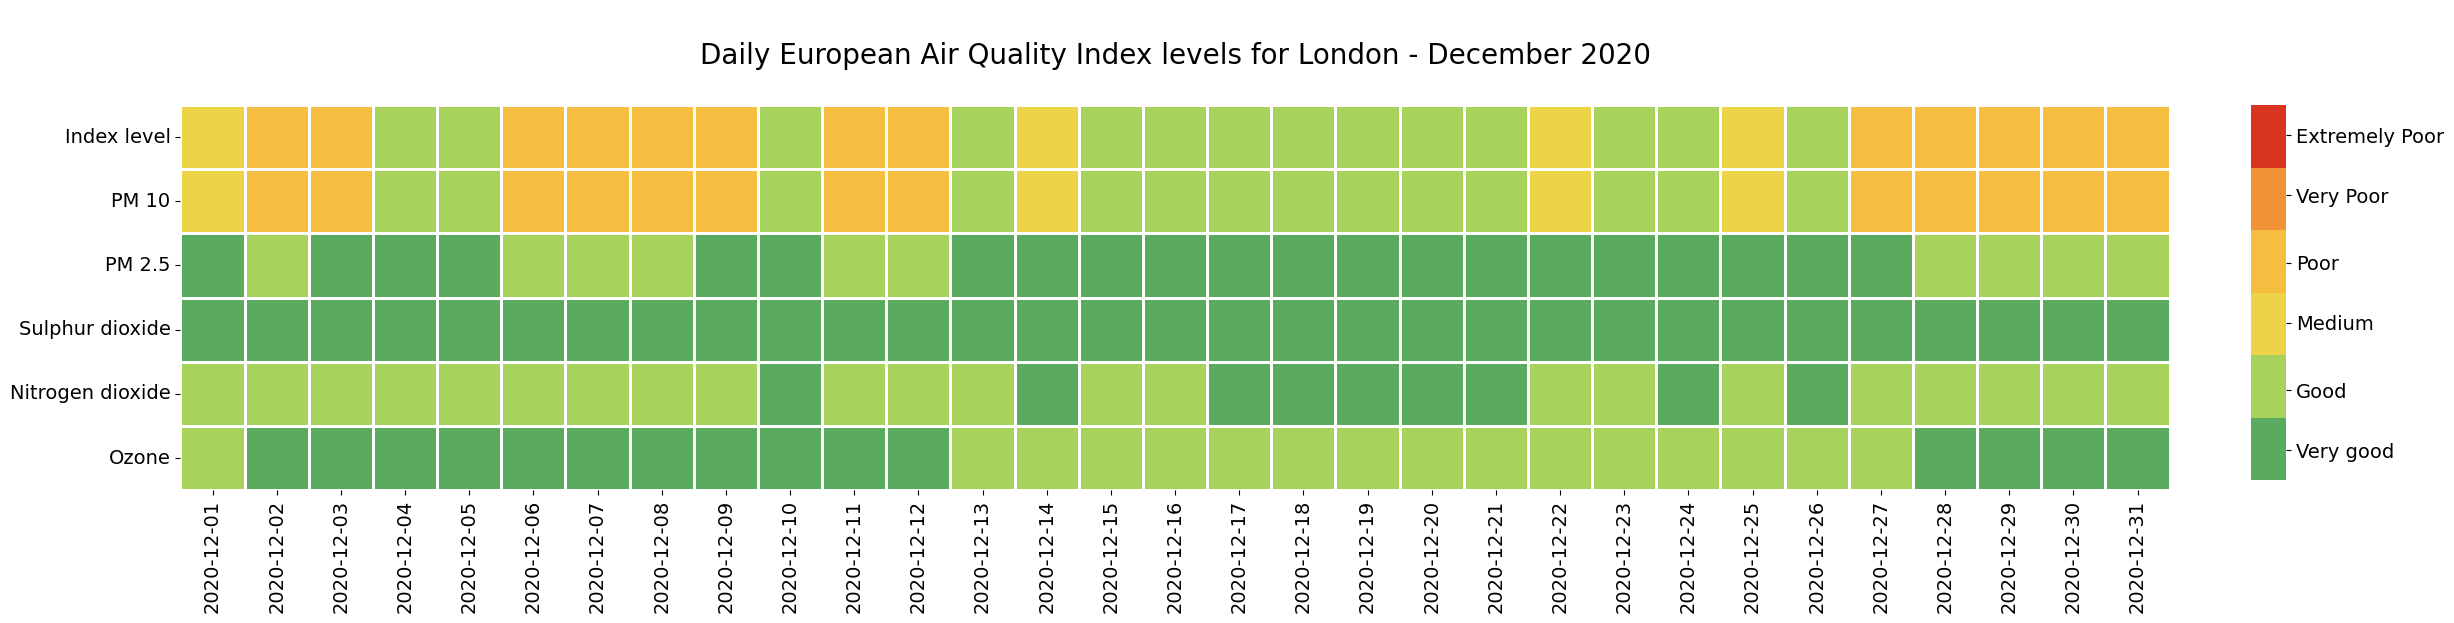

In [39]:
# Initiate the matplotlib figure
fig, ax = plt.subplots(1,1,figsize=(35,5))
cbar_ax = fig.add_axes([.82, .13, .01, .75])

# Plotting function
g = sns.heatmap(df, cmap=cmap, linewidth=1, linecolor='w', square=True, cbar_ax = cbar_ax,vmin=1, vmax=6, ax=ax)

# Set title of the heatmap
g.set_title("\nDaily European Air Quality Index levels for London - December 2020\n", fontsize=20)
g.set(xlabel=None)

# Customize x- and y-axis ticks and labels
ylabels=['Index level', 'PM 10', 'PM 2.5', 'Sulphur dioxide', 'Nitrogen dioxide', 'Ozone']
g.set_yticklabels(ylabels,fontsize=14, rotation=0)

xlabels=df.columns.format('%Y-%m-%d')[1::]
g.set_xticklabels(xlabels, fontsize=14)

# Customize colorbar entries
cbar = ax.collections[0].colorbar
cbar.set_ticks([1.4,2.2,3.1,3.9,4.8,5.6])
cbar.set_ticklabels(['Very good', 'Good', 'Medium', 'Poor', 'Very Poor', 'Extremely Poor'])
cbar.ax.tick_params(labelsize=14)


<br>

<hr>

<p></p>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>